In [203]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

In [204]:
df = pd.read_csv("data/jenny/final_preprocessed.csv")
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
df.head(3)

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,...,rolling_Level_mean_5,rolling_Temp_std_15,rolling_Temp_std_10,rolling_Temp_std_5,rolling_Flow_std_15,rolling_Flow_std_10,rolling_Flow_std_5,rolling_Level_std_15,rolling_Level_std_10,rolling_Level_std_5
0,2013-09-02,9,2013,19.127273,0.8755,0.5480,0.0,7.679129,28.3825,3.965188,...,0.8237,2.160008,1.950006,1.571429,2.041962,1.416962,0.74561,0.060489,0.042766,0.024903
1,2013-09-03,9,2013,18.045833,0.7905,0.5405,0.0,7.679129,28.3825,3.965188,...,0.8237,2.160008,1.950006,1.571429,2.041962,1.416962,0.74561,0.060489,0.042766,0.024903
2,2013-09-04,9,2013,17.062500,0.7490,0.5365,0.0,7.679129,28.3825,3.965188,...,0.8237,2.160008,1.950006,1.571429,2.041962,1.416962,0.74561,0.060489,0.042766,0.024903


In [205]:
df['count_diff'] = df['count'].diff().dropna()

def create_lags(df, variable, start_lag, end_lag):
      n = start_lag
      while n <= end_lag:
            df[f"{variable}_lag_{n}"] = df[f"{variable}"].shift(n)
            n += 1
      return df

df = create_lags(df, "count_diff", 31, 33)
df = create_lags(df, "Temp", 31, 33)
df = create_lags(df, "Flow", 31, 33)
df = create_lags(df, "Level", 31, 33)
df.tail(5)

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,...,count_diff_lag_33,Temp_lag_31,Temp_lag_32,Temp_lag_33,Flow_lag_31,Flow_lag_32,Flow_lag_33,Level_lag_31,Level_lag_32,Level_lag_33
3767,2023-12-27,12,2023,6.758333,28.499999,1.2440,0.0,0.996387,3.854583,1.01586,...,0.0,0.837500,0.679167,0.804167,5.455,5.905,6.410,0.7865,0.8010,0.8170
3768,2023-12-28,12,2023,8.962500,30.200000,1.2460,0.0,0.996387,3.854583,1.01586,...,0.0,2.525000,0.837500,0.679167,5.090,5.455,5.905,0.7735,0.7865,0.8010
3769,2023-12-29,12,2023,8.366667,31.400000,1.2680,0.0,0.996387,3.854583,1.01586,...,0.0,2.120833,2.525000,0.837500,4.745,5.090,5.455,0.7615,0.7735,0.7865
3770,2023-12-30,12,2023,8.645833,23.600000,1.1695,0.0,0.996387,3.854583,1.01586,...,0.0,2.329167,2.120833,2.525000,4.455,4.745,5.090,0.7510,0.7615,0.7735
3771,2023-12-31,12,2023,6.516667,18.800000,1.0930,0.0,0.996387,3.854583,1.01586,...,0.0,2.525000,2.329167,2.120833,4.245,4.455,4.745,0.7425,0.7510,0.7615


In [206]:
df.columns

Index(['date', 'month', 'year', 'Temp', 'Flow', 'Level', 'count',
       'october_Flow', 'november_Flow', 'december_Temp', 'january_Temp',
       'feburary_Temp', 'october_Level', 'november_Level',
       'rolling_Temp_mean_15', 'rolling_Temp_mean_10', 'rolling_Temp_mean_5',
       'rolling_Flow_mean_15', 'rolling_Flow_mean_10', 'rolling_Flow_mean_5',
       'rolling_Level_mean_15', 'rolling_Level_mean_10',
       'rolling_Level_mean_5', 'rolling_Temp_std_15', 'rolling_Temp_std_10',
       'rolling_Temp_std_5', 'rolling_Flow_std_15', 'rolling_Flow_std_10',
       'rolling_Flow_std_5', 'rolling_Level_std_15', 'rolling_Level_std_10',
       'rolling_Level_std_5', 'count_diff', 'count_diff_lag_31',
       'count_diff_lag_32', 'count_diff_lag_33', 'Temp_lag_31', 'Temp_lag_32',
       'Temp_lag_33', 'Flow_lag_31', 'Flow_lag_32', 'Flow_lag_33',
       'Level_lag_31', 'Level_lag_32', 'Level_lag_33'],
      dtype='object')

In [207]:
def impute_for_missing(df):
      missing_cols = df.columns[df.isna().any()].tolist()
      for col in missing_cols:
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
      return df

df = impute_for_missing(df)

In [208]:
def split_test_train(df, year=2023, summer_months=False):
      if summer_months:
            df = df[df["month"].isin([4,5,6,7,8])]
      train = df[df["year"] < year]
      test = df[df["year"] >= year]
      return train, test

train, test = split_test_train(df, year=2022, summer_months=True)
print(train.shape[0], test.shape[0])
print(train.shape[1], test.shape[1])

1224 306
45 45


In [209]:
# def remove_features(df, keyword):
#       keep = [col for col in df.columns.tolist() if keyword not in col]
#       df = df[keep]
#       return df

# df = remove_features(df, "Level")
# df.columns

In [219]:
# use_for_feats = df.iloc[:,7:].columns.tolist()
# use_for_feats.remove("count_diff")

use_for_feats = ['month', 
                 'october_Flow',
                 'november_Flow',
                 'december_Temp',
                 'january_Temp',
                 'feburary_Temp',
                 'rolling_Temp_mean_5',
                 'rolling_Flow_mean_5',
                 'count_diff_lag_31', 'count_diff_lag_32', 'count_diff_lag_33', 
                 'Flow_lag_31', 'Flow_lag_32', 'Flow_lag_33', 
                 'Temp_lag_31', 'Temp_lag_32', 'Temp_lag_33']

print(use_for_feats)

X_train = train[use_for_feats]
y_train = train['count_diff']

X_test = test[use_for_feats]
y_test = test['count_diff']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

['month', 'october_Flow', 'november_Flow', 'december_Temp', 'january_Temp', 'feburary_Temp', 'rolling_Temp_mean_5', 'rolling_Flow_mean_5', 'count_diff_lag_31', 'count_diff_lag_32', 'count_diff_lag_33', 'Flow_lag_31', 'Flow_lag_32', 'Flow_lag_33', 'Temp_lag_31', 'Temp_lag_32', 'Temp_lag_33']
RMSE: 176.68936981264685


In [220]:
test["pred"] = y_pred
test.tail(10)

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,...,Temp_lag_32,Temp_lag_33,Flow_lag_31,Flow_lag_32,Flow_lag_33,Level_lag_31,Level_lag_32,Level_lag_33,pred,pred_adjust
3640,2023-08-22,8,2023,16.787500,0.1810,0.5300,0.0,0.996387,3.854583,1.01586,...,22.741667,23.387500,0.2870,0.2950,0.3145,0.5455,0.5455,0.5475,-1.567358,0.0
3641,2023-08-23,8,2023,15.562500,0.1845,0.5315,0.0,0.996387,3.854583,1.01586,...,21.154167,22.741667,0.2775,0.2870,0.2950,0.5435,0.5455,0.5455,-1.567358,0.0
3642,2023-08-24,8,2023,15.841667,0.1945,0.5335,0.0,0.996387,3.854583,1.01586,...,20.191667,21.154167,0.3950,0.2775,0.2870,0.5550,0.5435,0.5455,-0.591878,0.0
3643,2023-08-25,8,2023,17.858333,0.2030,0.5360,0.0,0.996387,3.854583,1.01586,...,18.258333,20.191667,0.7395,0.3950,0.2775,0.5935,0.5550,0.5435,-3.416573,0.0
3644,2023-08-26,8,2023,18.779167,0.2155,0.5390,0.0,0.996387,3.854583,1.01586,...,15.641667,18.258333,0.6475,0.7395,0.3950,0.5860,0.5935,0.5550,-3.506167,0.0
3645,2023-08-27,8,2023,21.737500,0.2160,0.5400,0.0,0.996387,3.854583,1.01586,...,16.820833,15.641667,0.5640,0.6475,0.7395,0.5740,0.5860,0.5935,-3.092072,0.0
3646,2023-08-28,8,2023,20.358333,0.2120,0.5395,0.0,0.996387,3.854583,1.01586,...,17.979167,16.820833,0.5225,0.5640,0.6475,0.5690,0.5740,0.5860,-3.092072,0.0
3647,2023-08-29,8,2023,16.691667,0.2575,0.5455,0.0,0.996387,3.854583,1.01586,...,19.812500,17.979167,0.4690,0.5225,0.5640,0.5640,0.5690,0.5740,-0.267378,0.0
3648,2023-08-30,8,2023,17.050000,0.2555,0.5445,0.0,0.996387,3.854583,1.01586,...,19.520833,19.812500,0.4180,0.4690,0.5225,0.5590,0.5640,0.5690,-0.591878,0.0
3649,2023-08-31,8,2023,17.204167,0.2805,0.5480,0.0,0.996387,3.854583,1.01586,...,18.491667,19.520833,0.3800,0.4180,0.4690,0.5540,0.5590,0.5640,-0.591878,0.0


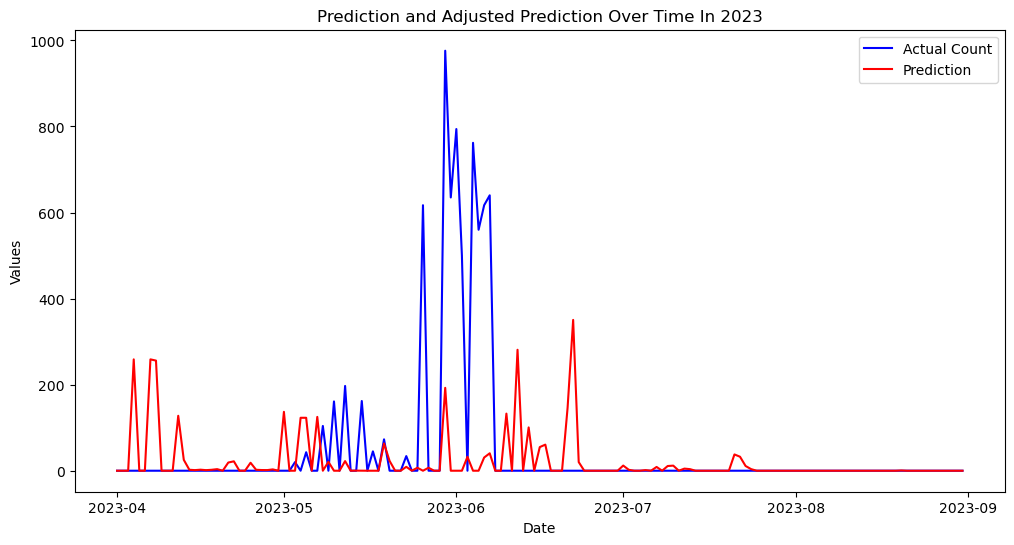

In [221]:
def plot_model(df, subset_year=None):
      df = df.set_index("date")
      if subset_year != None:
            df = df[df["year"] == subset_year]
      adjust_val = lambda row: 0 if row["pred"] <= 0 else row["pred"]
      if "pred_adjust" not in df.columns.tolist():
            df["pred_adjust"] = df.apply(adjust_val, axis=1)

      plt.figure(figsize=(12, 6))
      plt.plot(df.index, df['count'], label='Actual Count', color='blue')
      plt.plot(df.index, df['pred_adjust'], label='Prediction', color='red')

      plt.title(f'Prediction and Adjusted Prediction Over Time In {subset_year}')
      plt.xlabel('Date')
      plt.ylabel('Values')

      plt.legend()
      plt.show()

plot_model(test, 2023)

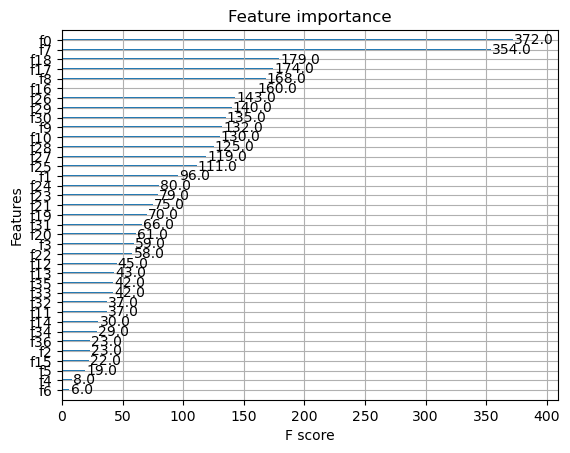

In [118]:
xgb.plot_importance(model)
plt.show()

In [222]:
def lasso_select(df, X_train, y_train, alpha=0.1):
      scaler = StandardScaler()
      X_scaled = scaler.fit_transform(X_train)
      lasso = Lasso(alpha=alpha)
      lasso.fit(X_scaled, y_train)
      selected_features = SelectFromModel(lasso, prefit=True).get_support()
      X_selected = X_train.loc[:, selected_features]
      X_list = X_selected.columns.tolist()
      print(f"Out of {len(df.columns.tolist())} features, we reduced it down to {len(X_list)} features.")
      return X_list

lasso_features = lasso_select(train, X_train, y_train, 0.15)
lasso_features

Out of 45 features, we reduced it down to 15 features.


['month',
 'november_Flow',
 'january_Temp',
 'feburary_Temp',
 'rolling_Temp_mean_5',
 'rolling_Flow_mean_5',
 'count_diff_lag_31',
 'count_diff_lag_32',
 'count_diff_lag_33',
 'Flow_lag_31',
 'Flow_lag_32',
 'Flow_lag_33',
 'Temp_lag_31',
 'Temp_lag_32',
 'Temp_lag_33']

In [223]:
def XGBoost_predict(X_train, y_train, X_test, y_test, select_feats):
      X_train = X_train[select_feats]
      X_test = X_test[select_feats]

      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)

      model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
      model.fit(X_train_scaled, y_train)

      y_pred = model.predict(X_test_scaled)

      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      print(f'RMSE: {rmse:.3f}')
      return y_pred, rmse

In [224]:
preds = XGBoost_predict(X_train, y_train, X_test, y_test, lasso_features)
test["pred"] = preds[0]
test

RMSE: 171.804


,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,...,Temp_lag_32,Temp_lag_33,Flow_lag_31,Flow_lag_32,Flow_lag_33,Level_lag_31,Level_lag_32,Level_lag_33,pred,pred_adjust
3132,2022-04-01,4,2022,5.879167,13.550000,1.0085,0.0,23.103871,66.455000,1.127608,...,7.020833,6.054167,55.349998,63.150002,19.300000,1.7095,1.7985,1.1240,3.524324,5.257455
3133,2022-04-02,4,2022,7.916667,12.605000,0.9875,0.0,23.103871,66.455000,1.127608,...,7.937500,7.020833,54.600000,55.349998,63.150002,1.6525,1.7095,1.7985,-1.059601,0.000000
3134,2022-04-03,4,2022,7.845833,14.540000,1.0335,0.0,23.103871,66.455000,1.127608,...,7.808333,7.937500,40.000000,54.600000,55.349998,1.4735,1.6525,1.7095,-2.769325,0.000000
3135,2022-04-04,4,2022,6.104167,64.000000,1.8390,0.0,23.103871,66.455000,1.127608,...,6.113043,7.808333,28.550000,40.000000,54.600000,1.3105,1.4735,1.6525,22.048607,0.000000
3136,2022-04-05,4,2022,6.875000,49.699999,1.6860,0.0,23.103871,66.455000,1.127608,...,6.020833,6.113043,22.800000,28.550000,40.000000,1.2085,1.3105,1.4735,8.053474,2.462636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,2023-08-27,8,2023,21.737500,0.216000,0.5400,0.0,0.996387,3.854583,1.015860,...,16.820833,15.641667,0.564000,0.647500,0.739500,0.5740,0.5860,0.5935,-0.743315,0.000000
3646,2023-08-28,8,2023,20.358333,0.212000,0.5395,0.0,0.996387,3.854583,1.015860,...,17.979167,16.820833,0.522500,0.564000,0.647500,0.5690,0.5740,0.5860,-0.631146,0.000000
3647,2023-08-29,8,2023,16.691667,0.257500,0.5455,0.0,0.996387,3.854583,1.015860,...,19.812500,17.979167,0.469000,0.522500,0.564000,0.5640,0.5690,0.5740,0.837220,0.000000
3648,2023-08-30,8,2023,17.050000,0.255500,0.5445,0.0,0.996387,3.854583,1.015860,...,19.520833,19.812500,0.418000,0.469000,0.522500,0.5590,0.5640,0.5690,-1.225269,0.000000


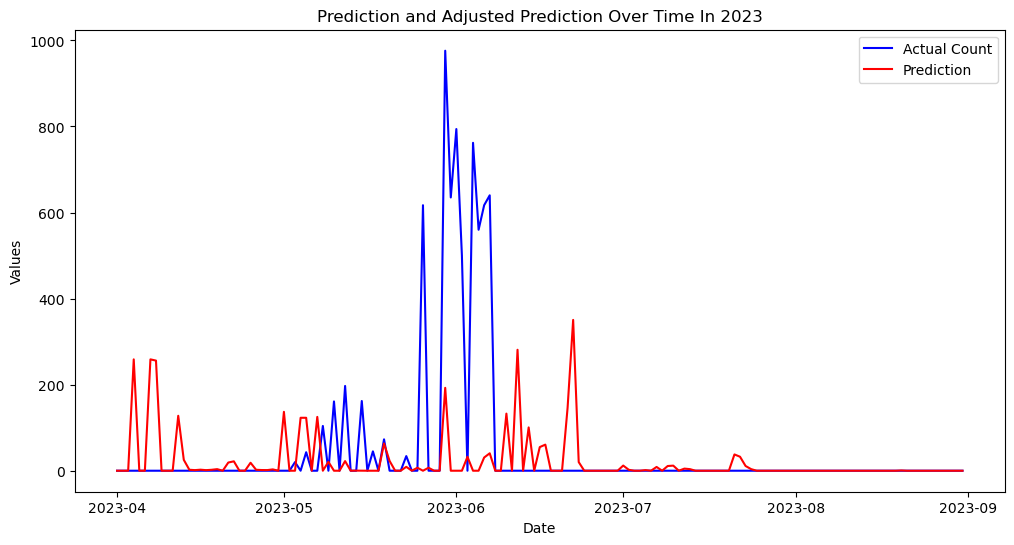

In [225]:
plot_model(test, 2023)

Currently investingating alpha value of: 0.100.
Out of 45 features, we reduced it down to 15 features.
RMSE: 171.804


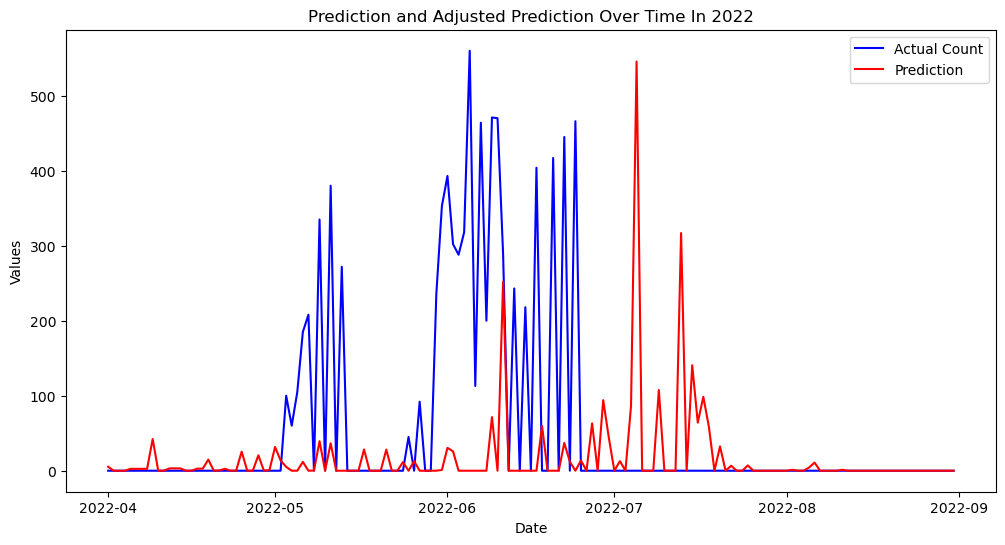

Currently investingating alpha value of: 0.150.
Out of 45 features, we reduced it down to 15 features.
RMSE: 171.804


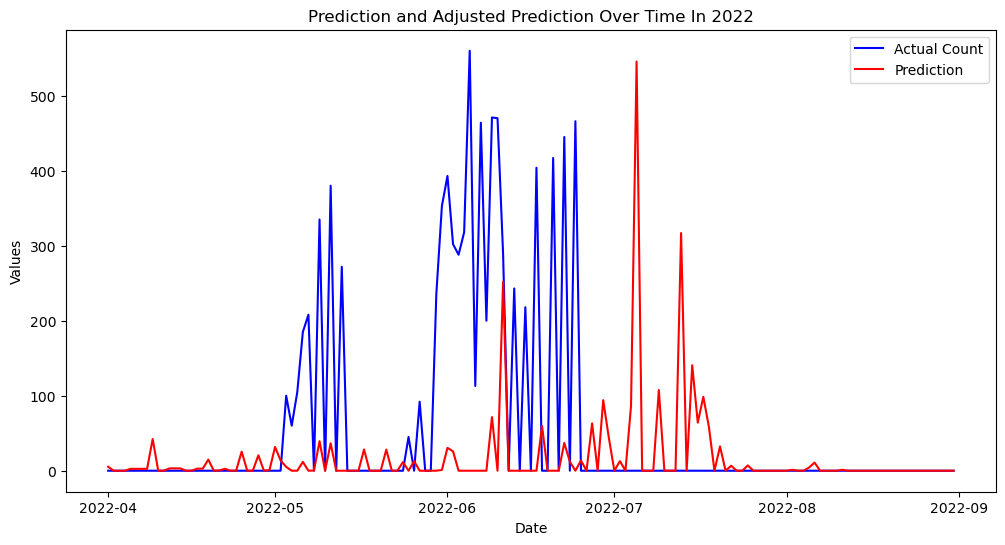

Currently investingating alpha value of: 0.200.
Out of 45 features, we reduced it down to 14 features.
RMSE: 176.496


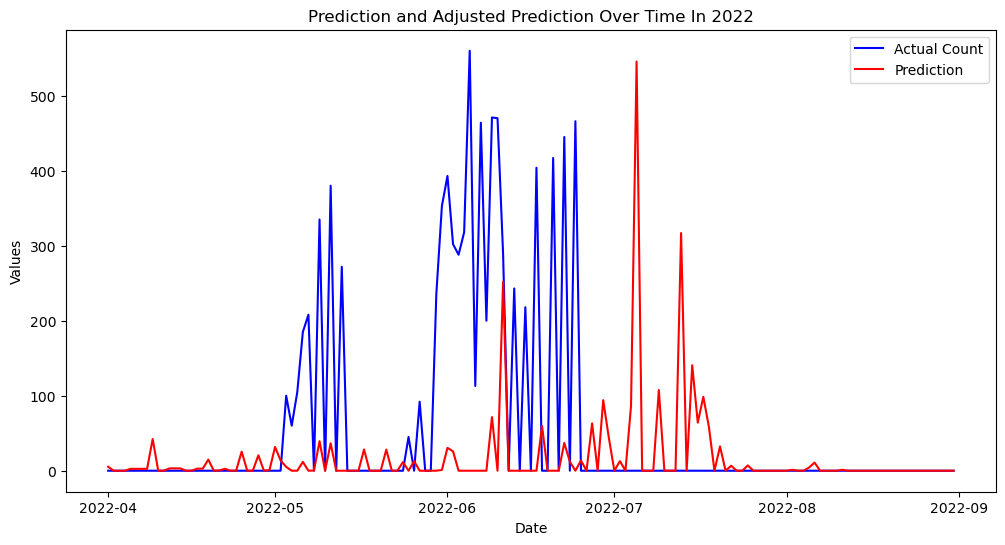

Currently investingating alpha value of: 0.250.
Out of 45 features, we reduced it down to 13 features.
RMSE: 176.933


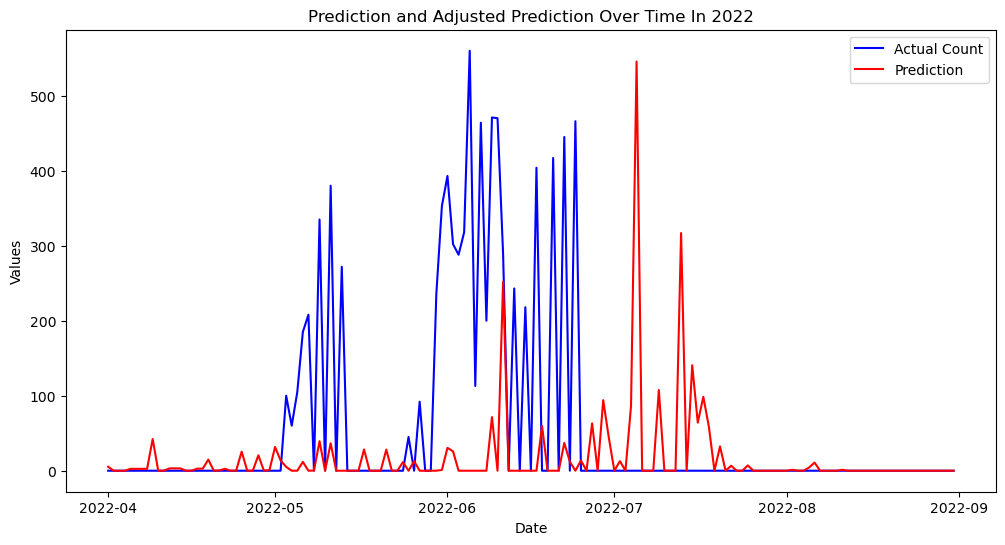

Currently investingating alpha value of: 0.300.
Out of 45 features, we reduced it down to 11 features.
RMSE: 161.037


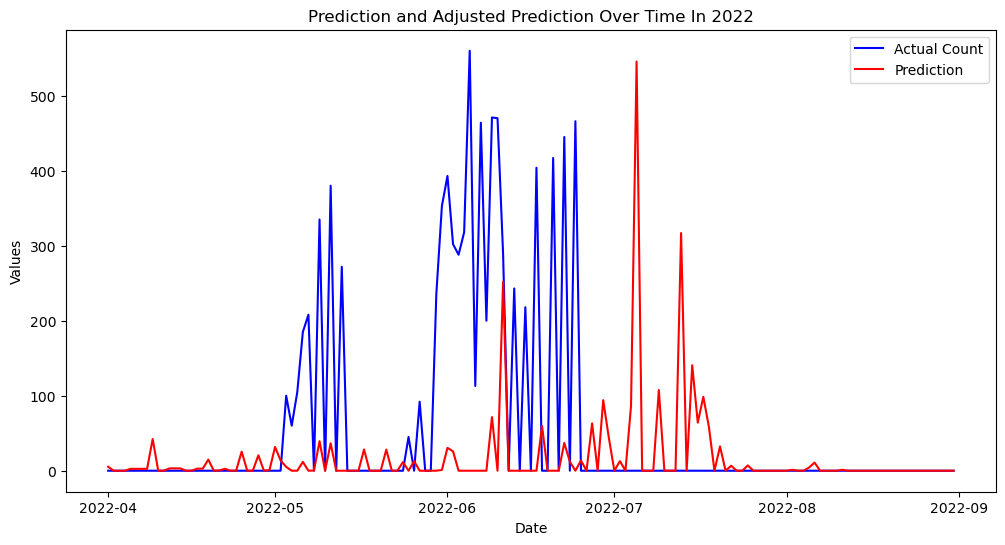

Currently investingating alpha value of: 0.350.
Out of 45 features, we reduced it down to 9 features.
RMSE: 164.893


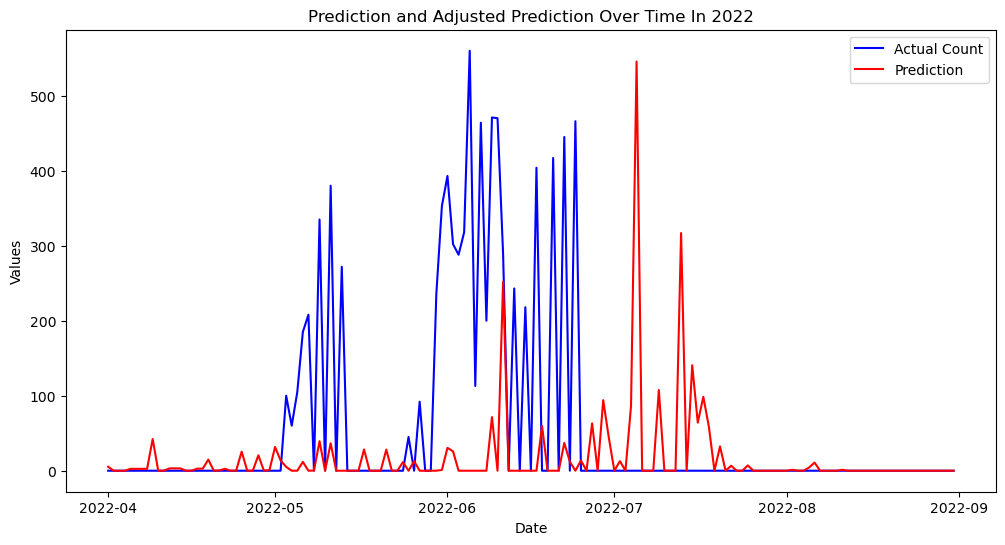

Currently investingating alpha value of: 0.400.
Out of 45 features, we reduced it down to 9 features.
RMSE: 164.893


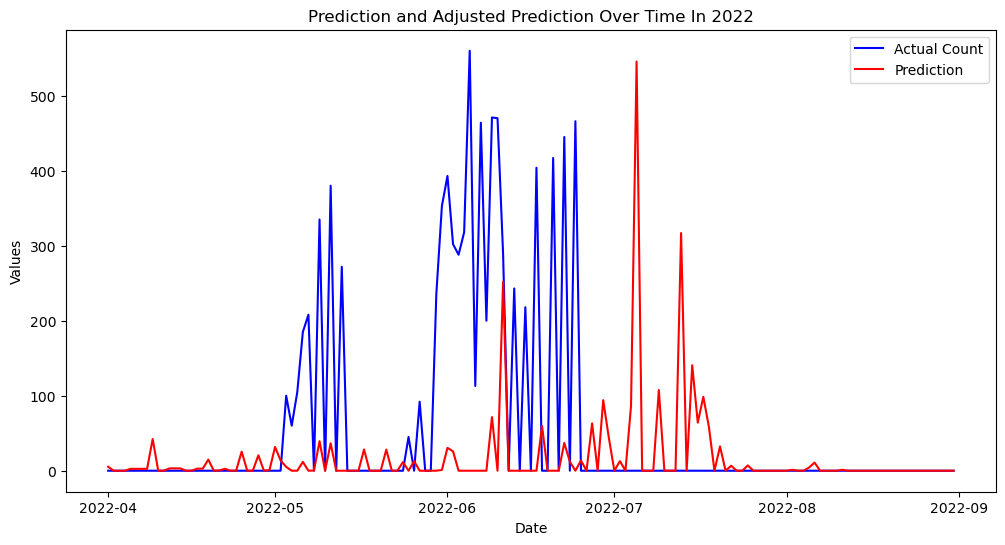

Currently investingating alpha value of: 0.450.
Out of 45 features, we reduced it down to 8 features.
RMSE: 178.416


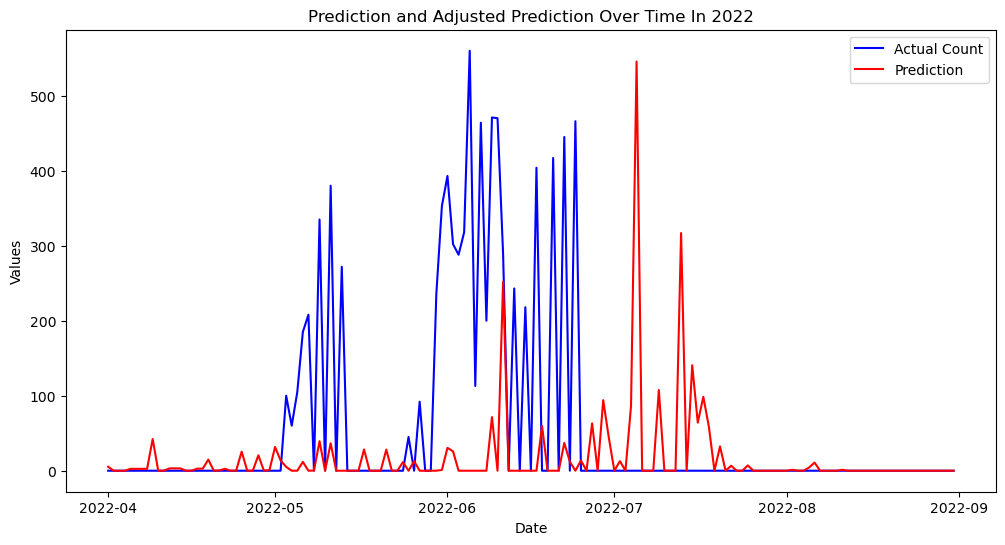

Currently investingating alpha value of: 0.500.
Out of 45 features, we reduced it down to 8 features.
RMSE: 178.416


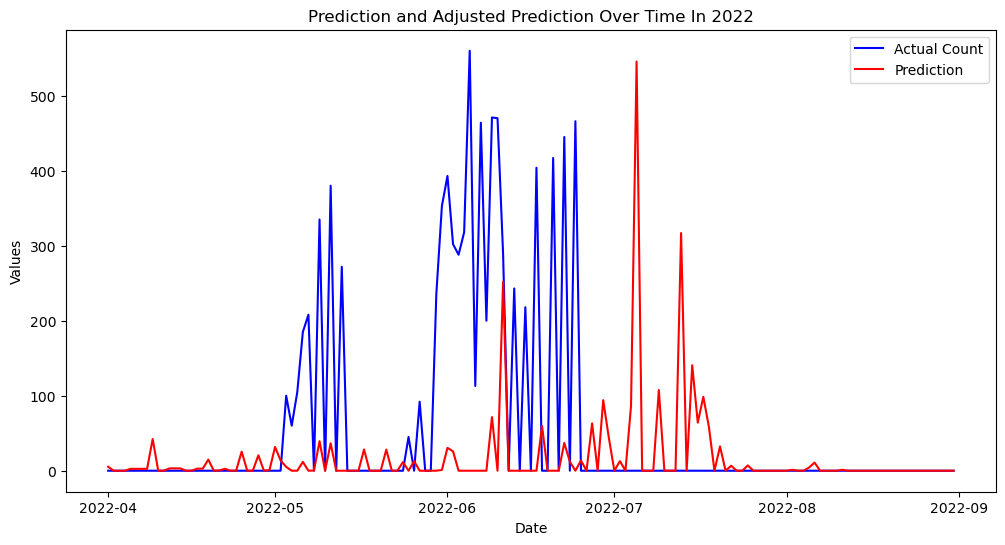

Currently investingating alpha value of: 0.550.
Out of 45 features, we reduced it down to 7 features.
RMSE: 171.830


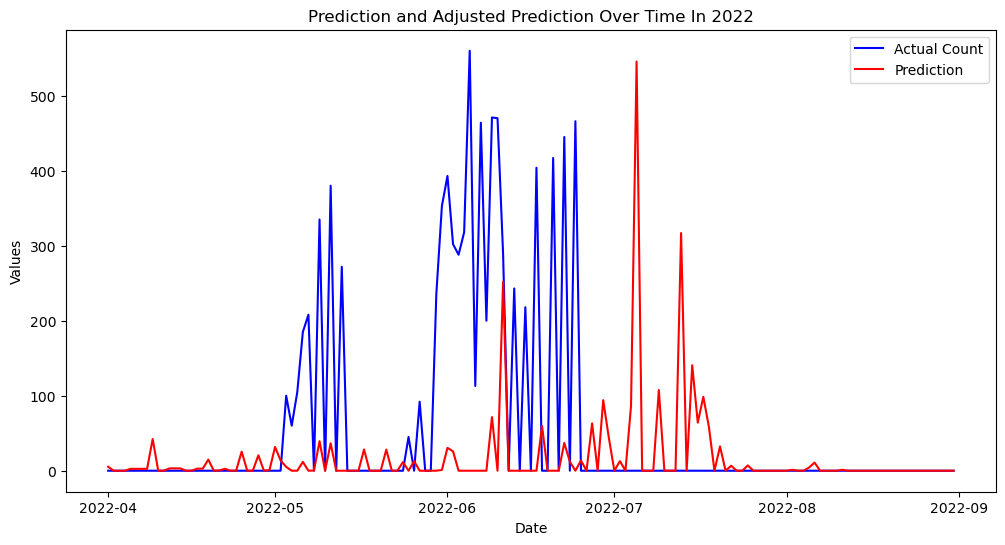

Currently investingating alpha value of: 0.600.
Out of 45 features, we reduced it down to 7 features.
RMSE: 171.830


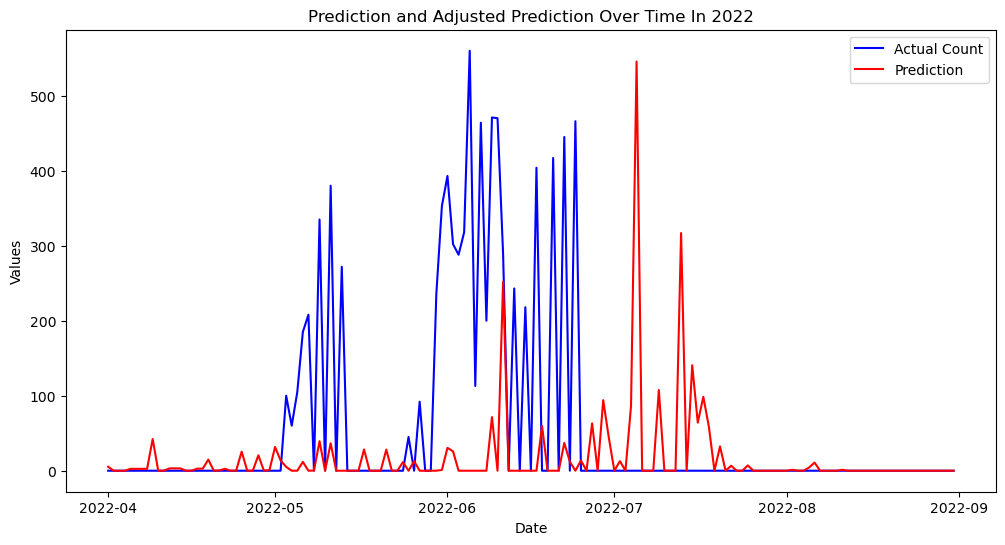

Currently investingating alpha value of: 0.650.
Out of 45 features, we reduced it down to 7 features.
RMSE: 171.830


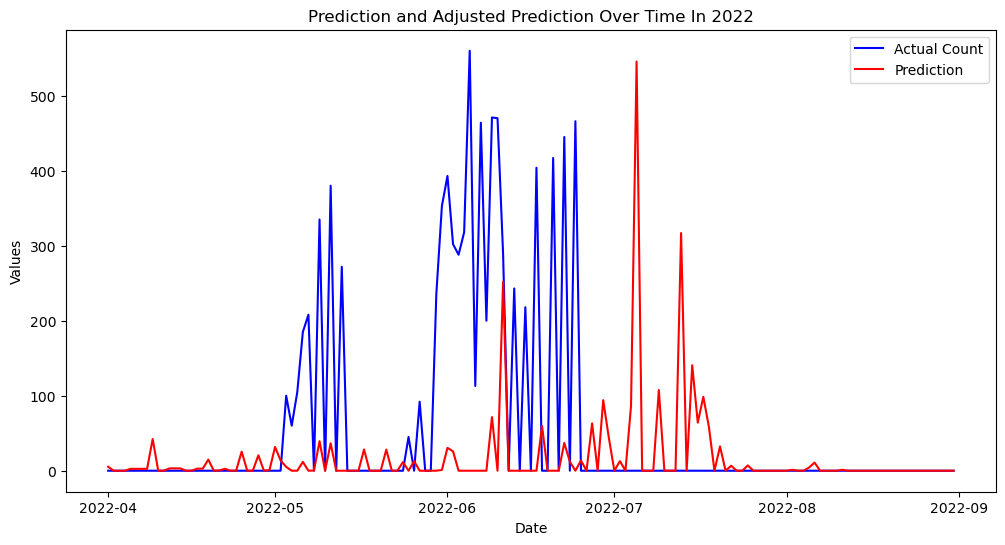

Currently investingating alpha value of: 0.700.
Out of 45 features, we reduced it down to 7 features.
RMSE: 171.830


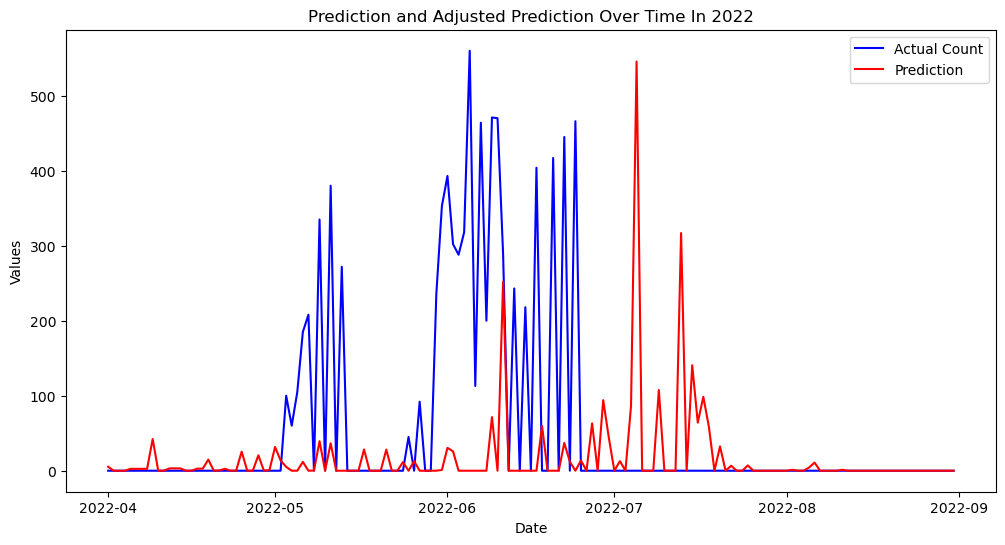

Currently investingating alpha value of: 0.750.
Out of 45 features, we reduced it down to 7 features.
RMSE: 171.830


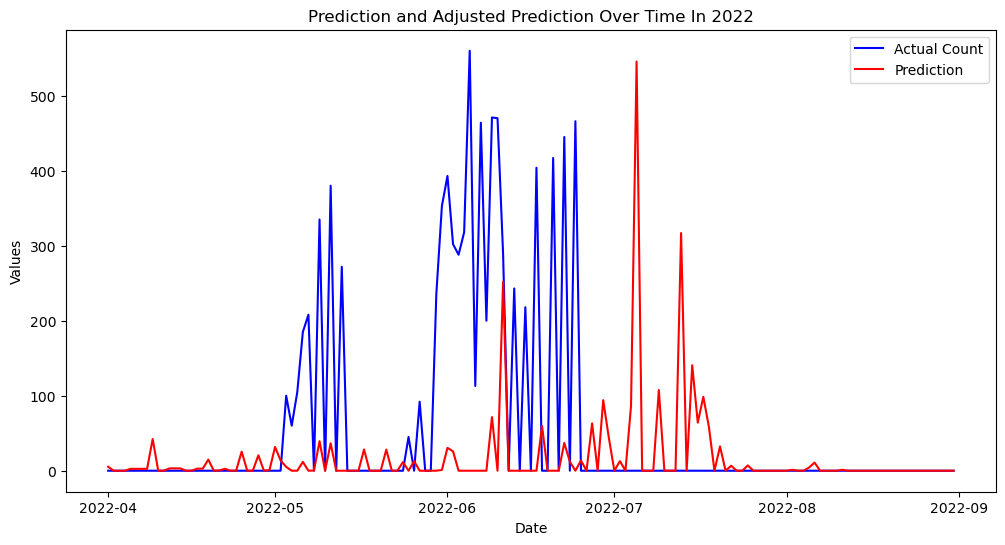

Currently investingating alpha value of: 0.800.
Out of 45 features, we reduced it down to 7 features.
RMSE: 171.830


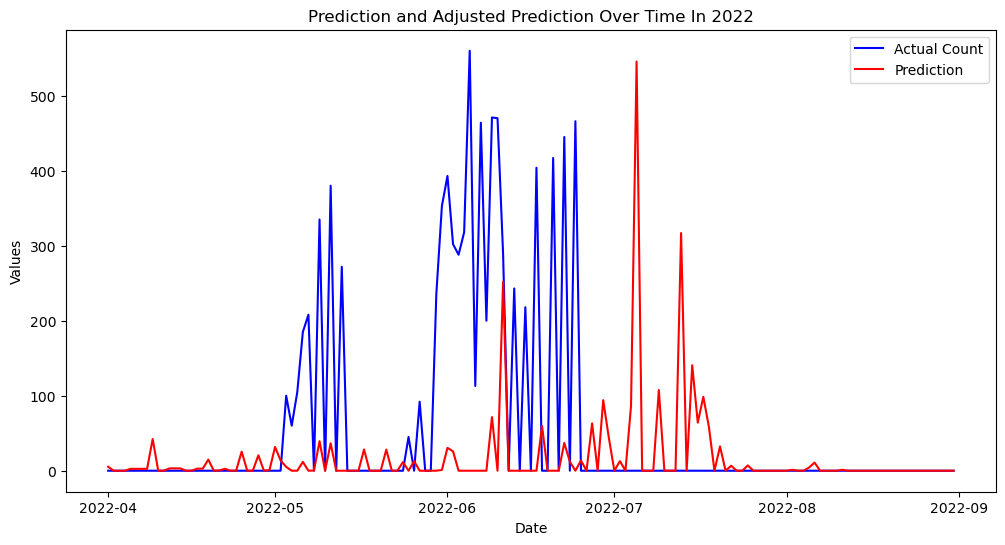

Currently investingating alpha value of: 0.850.
Out of 45 features, we reduced it down to 7 features.
RMSE: 171.830


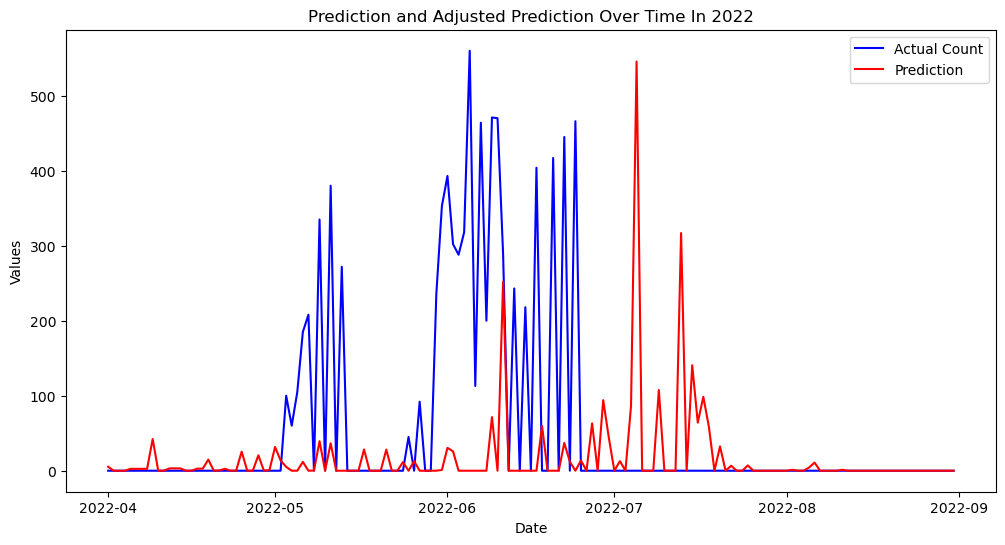

Currently investingating alpha value of: 0.900.
Out of 45 features, we reduced it down to 7 features.
RMSE: 171.830


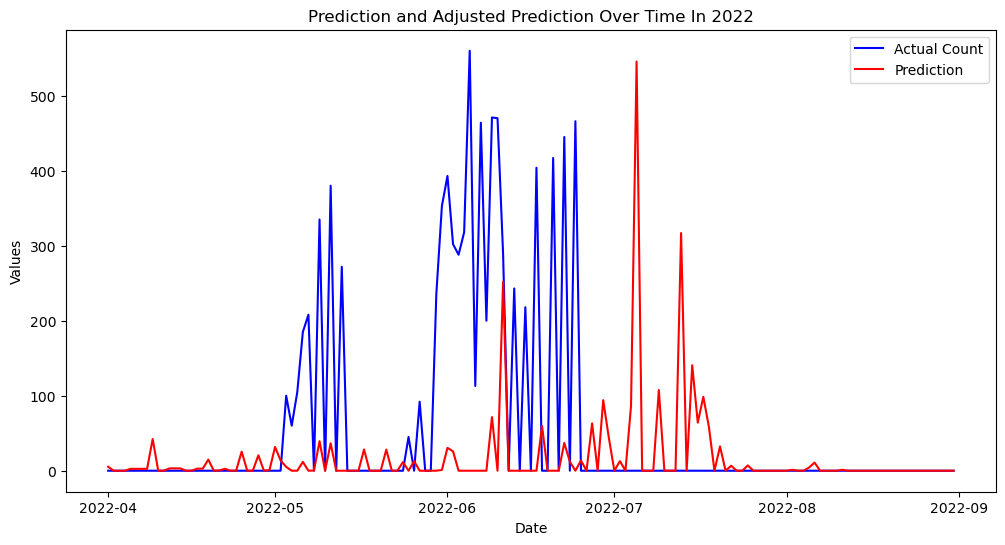

Currently investingating alpha value of: 0.950.
Out of 45 features, we reduced it down to 7 features.
RMSE: 171.830


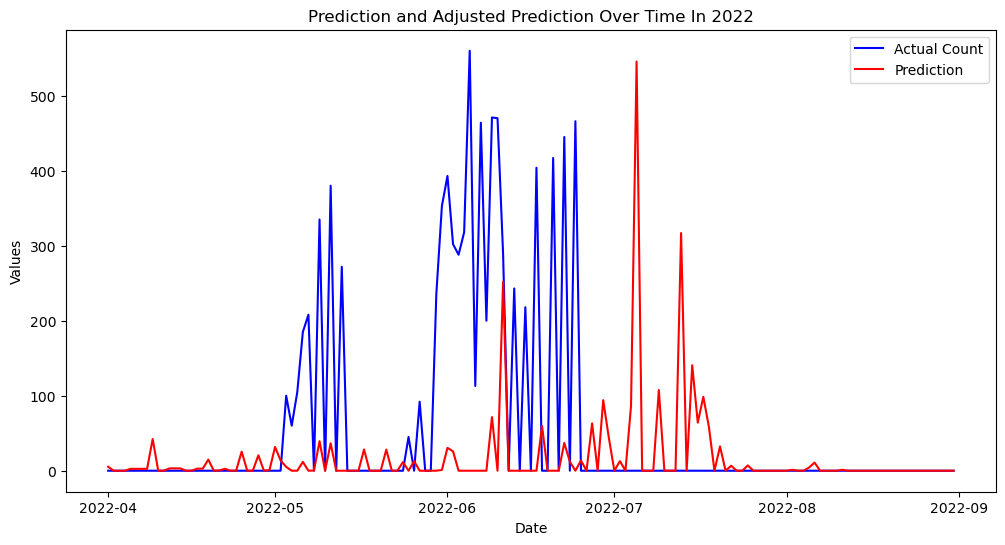

In [227]:
alpha_vals = np.arange(0.1, 1.0, 0.05)
alpha_dict = {}
for alpha in alpha_vals:
      temp_test = test.copy()
      print(f"Currently investingating alpha value of: {alpha:.3f}.")
      feats_lasso_select = lasso_select(train, X_train, y_train, alpha)
      preds, rmse = XGBoost_predict(X_train, y_train, X_test, y_test, feats_lasso_select)
      temp_test["pred"] = preds
      alpha_dict[alpha] = rmse
      plot_model(temp_test, 2022)

Out of 45 features, we reduced it down to 11 features.
RMSE: 161.037


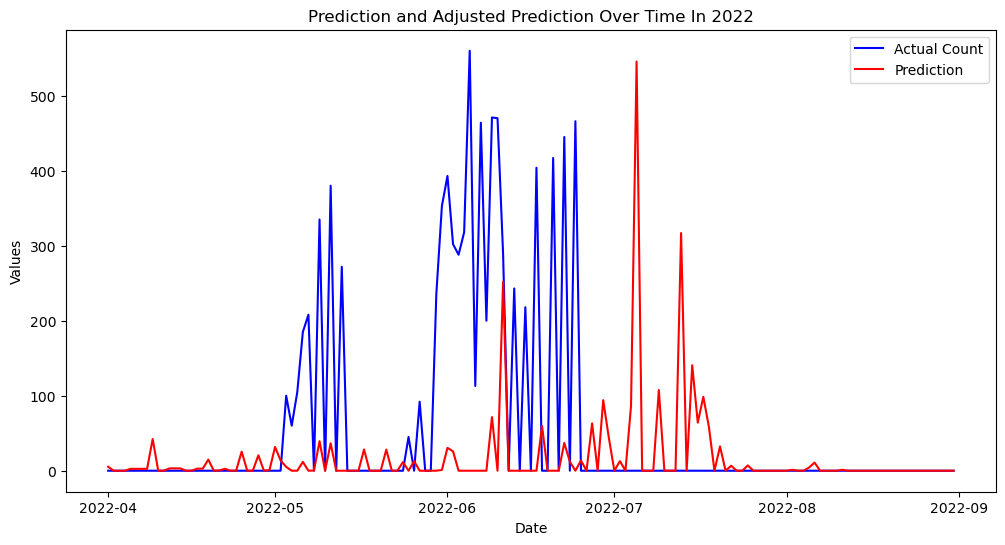

In [228]:
min_val = min(list(alpha_dict.values()))

def find_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key  
    return None

best_alpha = find_key_by_value(alpha_dict, min_val)
lasso_selected = lasso_select(train, X_train, y_train, best_alpha)
preds, rmse = XGBoost_predict(X_train, y_train, X_test, y_test, lasso_selected)

test["pred"] = preds
plot_model(test, 2022)

In [229]:
adjust_val = lambda row: 0 if row["pred"] <= 0 else row["pred"]
test["pred_adjust"] =test.apply(adjust_val, axis=1)

In [230]:
def find_date_simple(df, year=None, count_col="count", detect_num=10):
    df = df.reset_index()
    if year is not None:
        df = df[df["year"] == year]
    if df[count_col].max() <= detect_num:
        print("No date found with the specified condition.")
        return None
    for ind, row in df.iterrows():
        if row[count_col] > detect_num:
            date = row["date"]
            return date

find_date_simple(df, 2022)

Timestamp('2022-05-03 00:00:00')

In [231]:
# Actual Results
print(find_date_simple(df, year=2022, count_col="count", detect_num=5))
print(find_date_simple(df, year=2023, count_col="count", detect_num=5))

2022-05-03 00:00:00
2023-05-03 00:00:00


In [232]:
# Predicted Results
print(find_date_simple(test, year=2022, count_col="count", detect_num=5))
print(find_date_simple(test, year=2023, count_col="count", detect_num=5))

2022-05-03 00:00:00
2023-05-03 00:00:00


In [176]:
test_2023 = test[test["year"] == 2023]
test_2023[["date", "pred_adjust"]].head(10)

,date,pred_adjust
3497,2023-04-01,0.000000
3498,2023-04-02,221.645401
3499,2023-04-03,0.000000
3500,2023-04-04,0.000000
3501,2023-04-05,0.000000
3502,2023-04-06,0.000000
3503,2023-04-07,25.751459
3504,2023-04-08,224.108871
3505,2023-04-09,0.000000
3506,2023-04-10,97.799438


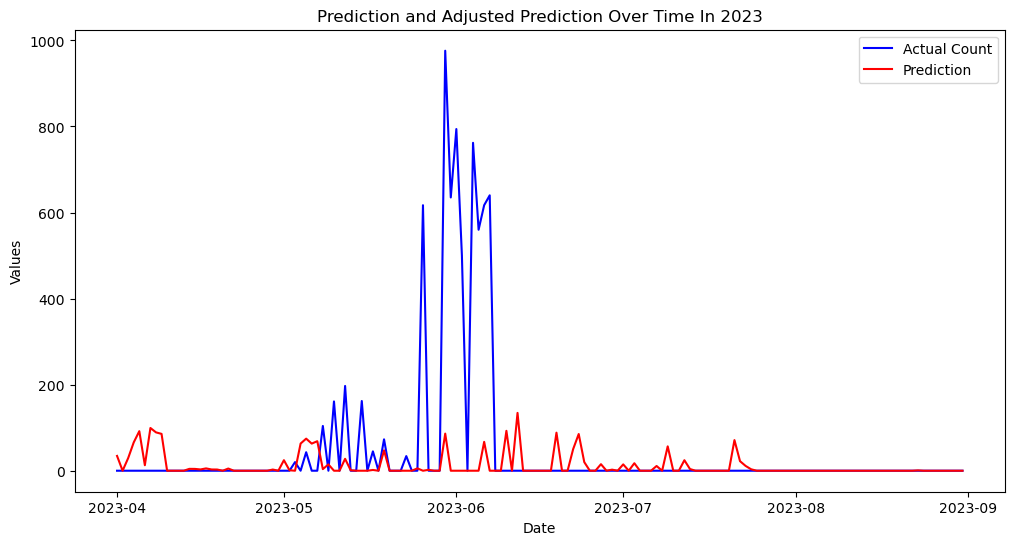

In [235]:
plot_model(test, 2023)

In [256]:
def implement_percentage(df, col):
      df[f"{col}_percentage"] = 0
      total_sum = df[f"{col}"].sum()
      for ind, row in df.iterrows():
            df.loc[ind, f"{col}_percentage"] = round(row[f"{col}"] / total_sum * 100, 3)
      return df

test_percentage = implement_percentage(test, "pred_adjust")
test_percentage = implement_percentage(test_percentage, "count")
test_percentage[["date", "count", "pred_adjust", "count_percentage", "pred_adjust_percentage"]].head(20)

/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_85258/2342717897.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.077' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[ind, f"{col}_percentage"] = round(row[f"{col}"] / total_sum * 100, 3)
/var/folders/c5/pphx1c0n3lb12sy85_ybqxqm0000gn/T/ipykernel_85258/2342717897.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.651' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[ind, f"{col}_percentage"] = round(row[f"{col}"] / total_sum * 100, 3)


,date,count,pred_adjust,count_percentage,pred_adjust_percentage
3132,2022-04-01,0.0,3.179785,0.0,0.077
3133,2022-04-02,0.0,0.000000,0.0,0.000
3134,2022-04-03,0.0,0.000000,0.0,0.000
3135,2022-04-04,0.0,7.334504,0.0,0.177
3136,2022-04-05,0.0,1.071808,0.0,0.026
3137,2022-04-06,0.0,0.422831,0.0,0.010
3138,2022-04-07,0.0,0.000000,0.0,0.000
3139,2022-04-08,0.0,0.000000,0.0,0.000
3140,2022-04-09,0.0,0.000000,0.0,0.000
3141,2022-04-10,0.0,0.000000,0.0,0.000


In [248]:
len(train)

1224

In [252]:
X_preds, X_rmse = XGBoost_predict(X_train, y_train, X_train, y_train, lasso_selected)
X_train_pred = X_train.copy()
X_train_pred["pred"] = X_preds

df_copy = df.copy()
df_copy = df_copy[df_copy["month"].isin([4,5,6,7,8])]
df_copy = df_copy[df_copy["year"] < 2022]
df_copy["year"].value_counts()
df_copy["pred"] = X_preds
adjust_val = lambda row: 0 if row["pred"] <= 0 else row["pred"]
df_copy["pred_adjust"] =df_copy.apply(adjust_val, axis=1)
df_copy[["date", "count", "pred_adjust"]]

RMSE: 67.847


,date,count,pred_adjust
210,2014-04-01,0.0,0.00000
211,2014-04-02,0.0,0.00000
212,2014-04-03,0.0,0.00000
213,2014-04-04,0.0,0.00000
214,2014-04-05,0.0,4.96666
...,...,...,...
2915,2021-08-27,0.0,0.00000
2916,2021-08-28,0.0,0.00000
2917,2021-08-29,0.0,0.00000
2918,2021-08-30,0.0,0.00000


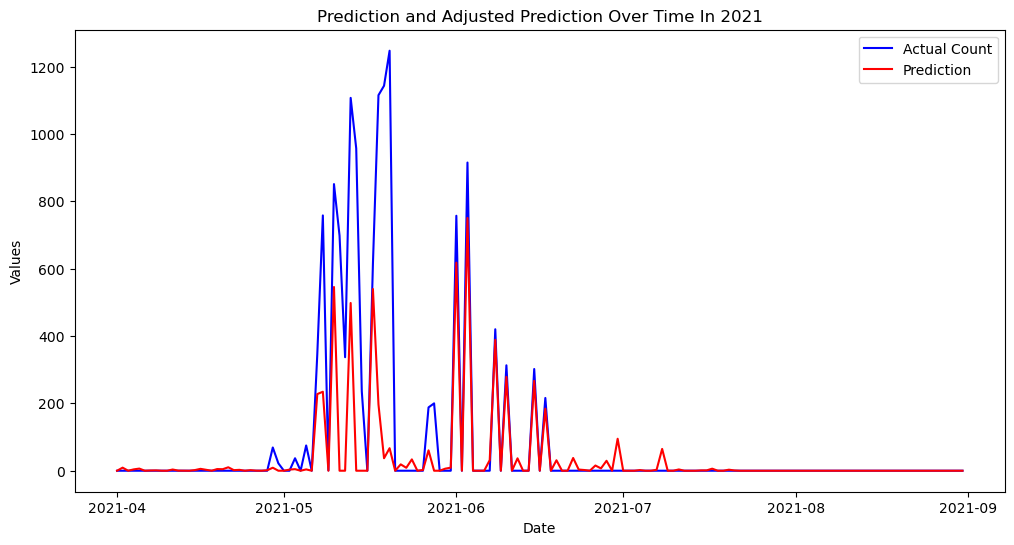

In [253]:
plot_model(df_copy, 2021)

In [195]:
def find_date(df, real_count, sub_year=None, observe_num=5, max_repeat=5, verbose=False):
    print(f"Finding {max_repeat} consecutive days of observing more than {observe_num} salmon.")
    df = df.reset_index()
    if sub_year is not None:
        df = df[df["year"] == sub_year]
    repeat_count = 0
    real_date = "Not defined"

    for ind, row in df.iterrows():
        if ind == 0:
            continue
        
        if verbose:
            print(f" Ind: {ind}, Date: {row['date']}, Count: {row[real_count]}")

        if (row[real_count] >= observe_num) and (df.loc[ind-1, real_count] >= observe_num):
            if verbose:
                print(f"----------------------{repeat_count+1}-----------------------")
            repeat_count += 1
        else:
            repeat_count = 0

        if repeat_count == max_repeat:
            print(f"Stopping at: {ind}, Date: {row['date']}")
            real_date = df.loc[ind, "date"]
            break

    return real_date


real_date = find_date(test, "pred_adjust", 2023, 5, 3, verbose=False)
real_date

Finding 3 consecutive days of observing more than 5 salmon.
Stopping at: 172, Date: 2023-04-20 00:00:00


Timestamp('2023-04-20 00:00:00')

In [218]:
find_date(df, "count", 2023, 5, 3, verbose=False)

Finding 3 consecutive days of observing more than 5 salmon.
Stopping at: 3559, Date: 2023-06-02 00:00:00


Timestamp('2023-06-02 00:00:00')

In [186]:
df[(df["year"] == 2023) & (df["month"].isin([4,5,6,7,8]))][["date", "count"]].head(40)

,date,count
3497,2023-04-01,0.0
3498,2023-04-02,0.0
3499,2023-04-03,0.0
3500,2023-04-04,0.0
3501,2023-04-05,0.0
3502,2023-04-06,0.0
3503,2023-04-07,0.0
3504,2023-04-08,0.0
3505,2023-04-09,0.0
3506,2023-04-10,0.0


In [201]:
def find_peak_dates(df, column, subset_year=None):
      df = df.reset_index()
      year_record = {}
      if subset_year != None:
            df = df[df["year"] == subset_year]

      for year in df["year"].unique().tolist():
            df_year = df[df["year"] == year]
            max_num_ind = df_year[column].idxmax()
            year_record[str(df.loc[max_num_ind, "date"])] = df.loc[max_num_ind, column]
      return year_record

find_peak_dates(df, "count", 2023)

{'2023-05-30 00:00:00': 976.0}

In [202]:
find_peak_dates(test, "pred_adjust", 2023)

{'2023-07-03 00:00:00': 235.42608642578125}